# Análisis de Regresión (II)

En este cuaderno, veremos cómo el análisis de regresión puede ayudar a **entender el comportamiento de los datos**, **predecir valores de datos** (continuos o dicotómicos), y **encontrar predictores importantes** (modelos dispersos).
Presentamos diferentes modelos de regresión: regresión lineal simple, regresión lineal múltiple y regresión polinómica.
Evaluamos los resultados cualitativamente mediante herramientas de visualización de Seaborn y cuantitativamente mediante la biblioteca Scikit-learn, así como otras herramientas.

Usamos diferentes conjuntos de datos reales:
* Conjunto de datos macroeconómicos
* Predicción del precio de un nuevo mercado de viviendas
* Extensión del hielo marino y cambio climático
* Conjunto de datos de diabetes de Scikit-learn
* Conjunto de datos Longley de datos macroeconómicos de EE. UU.
* Conjunto de datos de publicidad

### Contenidos del cuaderno:

- Regresión Lineal Múltiple
- Regularización: Ridge y Lasso
- Transformación de Datos

In [2]:
# Settings for the visualizations
import matplotlib.pylab as plt
%matplotlib inline 
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [4]:
seed = 1 # to make this notebook's output stable across runs

## Ejemplo 1: Vivienda en Boston

Continuemos con nuestro conjunto de datos de Vivienda en Boston.

In [6]:
# Load dataset
from sklearn import datasets
boston = datasets.load_boston() # Dictionary-like object that exposes its keys as attributes.
X,y = boston.data, boston.target # Create X matrix and y vector from the dataset.
features = boston.feature_names
print('feature names: {}'.format(boston.feature_names))
print('Shape of data: {} {}'.format(X.shape, y.shape))

feature names: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
Shape of data: (506, 13) (506,)


In [7]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [8]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=seed)

print('Train and test sizes of X: {} {}'.format(X_train.shape, X_test.shape))
print('Train and test sizes of y: {} {}'.format(y_train.shape, y_test.shape))

Train and test sizes of X: (50, 13) (456, 13)
Train and test sizes of y: (50,) (456,)


In [9]:
# Fitting a multiple linear model
lr = LinearRegression() # Create the Linear Regression estimator
lr.fit(X_train, y_train) # Perform the fitting


# Regrerssion coefs
coefs_lr = pd.Series(np.abs(lr.coef_), features).sort_values()

# Prediction
y_test_pred = lr.predict(X_test)

# evaluation
mse = mean_squared_error(y_test, y_test_pred)
r2score_train = lr.score(X_train, y_train)
r2score_test = lr.score(X_test, y_test)

# The coefficients
print('\nIntercept and coefs:\n{} {}'.format(lr.intercept_, lr.coef_))
# The mean squared error
print('\nMSE: {}'.format(mse))
# The coefficient of determination: 1 is perfect prediction
print('R^2 Score: {}'.format(r2score_train))
print('R^2 Score: {}'.format(r2score_test))


Intercept and coefs:
35.408376341682086 [-8.41554488e-02  7.42444001e-02  2.54853866e-01  1.77639409e+00
 -2.53858364e+01  5.25942814e+00 -2.49342023e-02 -1.21705452e+00
  3.24536403e-01 -2.60734240e-02 -9.98220746e-01 -6.91240503e-03
 -8.21871604e-02]

MSE: 32.83855497210274
R^2 Score: 0.8677571093777259
R^2 Score: 0.6224709227757259


In [10]:
# Plotting abs value of model coefficients
coefs_lr.plot(kind='bar', title='Model Coefficients')

<Axes: title={'center': 'Model Coefficients'}>

In [11]:
coefs_lr

B           0.006912
AGE         0.024934
TAX         0.026073
ZN          0.074244
LSTAT       0.082187
CRIM        0.084155
INDUS       0.254854
RAD         0.324536
PTRATIO     0.998221
DIS         1.217055
CHAS        1.776394
RM          5.259428
NOX        25.385836
dtype: float64

Podemos ver que todos los coeficientes obtenidos son diferentes de cero, lo que significa que no se descarta ninguna variable.
A continuación, intentaremos construir un nuevo modelo para predecir el precio utilizando los factores más importantes y descartando los no informativos. Para hacer esto, podemos crear un regresor LASSO, forzando coeficientes a cero (ver más abajo).

In [13]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Modelos de Regularización

### Regularización L2: Regresión Ridge

La Regresión Ridge penaliza los coeficientes si estos están demasiado alejados de cero, obligándolos a ser pequeños de manera continua. De esta manera, reduce la complejidad del modelo mientras mantiene todas las variables en el modelo.

$$ minimize(\sum_{i=0}^n (y_i - \beta_0- \sum_{j=1}^p \beta_jx_{ij})^2 + \alpha\sum_{j=1}^p \beta_j^2) $$

donde $\beta_j$ son los coeficientes de regresión.


### Regularización L1: Regresión Lasso

A menudo, en problemas reales, hay variables no informativas en los datos que impiden un modelado adecuado del problema y, por lo tanto, la construcción de un modelo de regresión correcto. En tales casos, un proceso de selección de características es crucial para seleccionar solo las características informativas y descartar las no informativas. Esto se puede lograr mediante métodos dispersos que utilizan un enfoque de penalización, como *Lasso* (operador de encogimiento y selección absoluta mínima) para establecer algunos coeficientes del modelo a cero (descartando así esas variables). La dispersión puede verse como una aplicación de la navaja de Occam: preferir modelos más simples a los complejos.

Para ello, la regresión Lasso añade un término de regularización de **norma $\ell_1$** a la suma de errores cuadráticos de predicción (SSE). Dado el conjunto de muestras (𝑋,𝐲), el objetivo es minimizar:

$$ minimize(\sum_{i=0}^n (y_i - \beta_0- \sum_{j=1}^p \beta_jx_{ij})^2 + \alpha\sum_{j=1}^p|\beta_j|)$$

### Interpretación geométrica de la regularización

El panel izquierdo muestra la regularización L1 (regularización lasso) y el panel derecho la regularización L2 (regresión Ridge). Las elipses indican la distribución para no regularización. Las formas (cuadrado y círculo) muestran las restricciones debido a la regularización (limitando $\theta^2$ para la regresión Ridge y $|\theta|$ para la regresión Lasso). Las esquinas de la regularización L1 crean más oportunidades para que la solución tenga ceros en algunos de los pesos.

<center><img src="files/images/regularization-ridge-lasso.png"></center>

Más información [aquí](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)

### Ridge


In [17]:
## Ridge Regression
ridge = linear_model.Ridge(alpha=1) # Create a Ridge regressor
ridge.fit(X_train, y_train) # Perform the fitting

# Regrerssion coefs
coefs_ridge = pd.Series(np.abs(ridge.coef_), features).sort_values()

# Prediction
y_test_pred_ridge = ridge.predict(X_test)

# evaluation
mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
r2score_ridge_train = ridge.score(X_train, y_train)
r2score_ridge_test = ridge.score(X_test, y_test)

# The coefficients
print('\nIntercept and coefs:\n{} {}'.format(ridge.intercept_, ridge.coef_))
# The mean squared error
print('\nMSE: {}'.format(mse_ridge))
# The coefficient of determination: 1 is perfect prediction
print('R^2 Score train: {}'.format(r2score_ridge_train))
print('R^2 Score test: {}'.format(r2score_ridge_test))


Intercept and coefs:
23.608335178037724 [-5.53778401e-02  9.99910460e-02  1.43443088e-01  1.21867927e+00
 -2.77148403e+00  4.09878537e+00 -2.45312926e-02 -9.48943959e-01
  4.49818982e-01 -3.89067830e-02 -5.11308982e-01  8.83852205e-04
 -2.07031918e-01]

MSE: 32.722556394088485
R^2 Score train: 0.8434071369784994
R^2 Score test: 0.6238045026532282


In [18]:
# Plotting abs value of model coefficients
coefs_ridge.plot(kind='bar', title='Ridge Coefficients')

<Axes: title={'center': 'Ridge Coefficients'}>

### Lasso


**Para completar:**
Ajusta un regresor Lasso y evalúalo.

In [21]:
## Lasso Regression
lasso = linear_model.Lasso(alpha=1)
lasso.fit(X_train, y_train)

# Regrerssion coefs
coefs_lasso = pd.Series(np.abs(lasso.coef_), features).sort_values()

# Prediction
y_test_pred_lasso = lasso.predict(X_test)

# evaluation
mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)

r2score_lasso_train = lasso.score(X_train, y_train)
r2score_lasso_test = lasso.score(X_test, y_test)


# The coefficients

# The mean squared error

# The coefficient of determination: 1 is perfect prediction
print(mse_lasso)
print(r2score_lasso_train, r2score_lasso_test)



43.977360195655386
0.7761459011960173 0.4944134348320204


In [22]:
# Plotting abs value of model coefficients
coefs_lasso.plot(kind='bar', title='Lasso Coefficients')

<Axes: title={'center': 'Lasso Coefficients'}>

In [23]:
coefs_lasso

CHAS       0.000000
NOX        0.000000
RM         0.000000
PTRATIO    0.000000
B          0.005361
INDUS      0.036006
AGE        0.041547
CRIM       0.049534
TAX        0.049926
ZN         0.128158
LSTAT      0.505767
DIS        0.608622
RAD        0.632474
dtype: float64

#### Comparar los resultados:

In [25]:
# Are the coeficients now sparse?
# Is the score different?

In [26]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

coefs_lr.plot(kind="barh", title='coefs_lr', ax=ax1)
coefs_ridge.plot(kind="barh", title='coefs_ridge', ax=ax2)
coefs_lasso.plot(kind="barh", title='coefs_lasso', ax=ax3)

<Axes: title={'center': 'coefs_lasso'}>

In [27]:
print('Non important variables: {}'.format(coefs_lasso.index[coefs_lasso==0].values))
print('Most important variable: {}'.format(coefs_lasso.index[-1]))

Non important variables: ['CHAS' 'NOX' 'RM' 'PTRATIO']
Most important variable: RAD


In [28]:
scores = [[r2score_train, r2score_test],
         [r2score_ridge_train, r2score_ridge_test],
         [r2score_lasso_train, r2score_lasso_test]]
df_scores = pd.DataFrame(scores, columns=["Train", "Test"], index=["No regularization", "Ridge", "Lasso"])
#df_scores.sort_values(by="test_score", ascending=False, inplace=True)
df_scores

,Train,Test
No regularization,0.867757,0.622471
Ridge,0.843407,0.623805
Lasso,0.776146,0.494413


## Transforma y Predice:

In [30]:
# Look at mean and average values of our predictors
for i, feat in enumerate(features):
    print()
    print(feat)
    print("Max {}, min {}, mean {}, and var {}".format(np.max(X[:, i]), np.min(X[:, i]), np.mean(X[:, i]), np.var(X[:, i])))


CRIM
Max 88.9762, min 0.00632, mean 3.613523557312254, and var 73.84035966507905

ZN
Max 100.0, min 0.0, mean 11.363636363636363, and var 542.8618397412864

INDUS
Max 27.74, min 0.46, mean 11.13677865612648, and var 46.97142974152072

CHAS
Max 1.0, min 0.0, mean 0.0691699604743083, and var 0.06438547704229093

NOX
Max 0.871, min 0.385, mean 0.5546950592885376, and var 0.013401098888632846

RM
Max 8.78, min 3.561, mean 6.284634387351779, and var 0.49269521612976297

AGE
Max 100.0, min 2.9, mean 68.57490118577076, and var 790.7924728163227

DIS
Max 12.1265, min 1.1296, mean 3.795042687747036, and var 4.425252261616491

RAD
Max 24.0, min 1.0, mean 9.549407114624506, and var 75.66653126904029

TAX
Max 711.0, min 187.0, mean 408.2371541501976, and var 28348.62359980628

PTRATIO
Max 22.0, min 12.6, mean 18.455533596837945, and var 4.677726296302081

B
Max 396.9, min 0.32, mean 356.6740316205534, and var 8318.280420504929

LSTAT
Max 37.97, min 1.73, mean 12.653063241106722, and var 50.893979

Existe un tipo especial de ``Estimator`` llamado ``Transformer`` que transforma los datos de entrada, por ejemplo, selecciona un subconjunto de las características o extrae nuevas características basadas en las originales.

Un transformador que utilizaremos aquí es ``sklearn.preprocessing.StandardScaler``. Este transformador centra cada predictor en ``X`` para tener media cero y varianza unitaria y es útil.

In [32]:
# Train test split
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_train) # Create the transformer StandardScaler and perform the fitting for the training data

X_train_norm = scalerX.transform(X_train)
X_test_norm = scalerX.transform(X_test)

print("\nBefore transformation:")
print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train), np.min(X_train), np.mean(X_train), np.var(X_train)))
print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_test), np.min(X_test), np.mean(X_test), np.var(X_test)))

print("\nAfter transformation:")
print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train_norm), np.min(X_train_norm), np.mean(X_train_norm), np.var(X_train_norm)))
print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_test_norm), np.min(X_test_norm), np.mean(X_test_norm), np.var(X_test_norm)))


Before transformation:
Train: Max 666.0, min 0.0, mean 72.19228883076923, and var 21778.722090162235
Test: Max 711.0, min 0.0, mean 69.84169491902834, and var 20991.888021571125

After transformation:
Train: Max 4.65818871161953, min -5.308456227469241, mean -3.853327913160543e-16, and var 0.9999999999999998
Test: Max 11.45694924208993, min -6.93444941066249, mean -0.048888297589274335, and var 1.2415175023679657


In [33]:
for i, feat in enumerate(features):
    print()
    print(feat)
    print("\nBefore transformation:")
    print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train[:, i]), np.min(X_train[:, i]), np.mean(X_train[:, i]), np.var(X_train[:, i])))
    print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_test[:, i]), np.min(X_test[:, i]), np.mean(X_test[:, i]), np.var(X_test[:, i])))

    print("\nAfter transformation:")
    print('Train: Max {}, min {}, mean {}, and var {}'.format(np.max(X_train_norm[:, i]), np.min(X_train_norm[:, i]), np.mean(X_train_norm[:, i]), np.var(X_train_norm[:, i])))
    print('Test: Max {}, min {}, mean {}, and var {}'.format(np.max(X_test_norm[:, i]), np.min(X_test_norm[:, i]), np.mean(X_test_norm[:, i]), np.var(X_test_norm[:, i])))



CRIM

Before transformation:
Train: Max 38.3518, min 0.02731, mean 3.6663588000000003, and var 55.44473205324656
Test: Max 88.9762, min 0.00632, mean 3.607730219298246, and var 75.85708444101574

After transformation:
Train: Max 4.65818871161953, min -0.48871732504277926, mean -1.8984813721090176e-16, and var 1.0000000000000002
Test: Max 11.45694924208993, min -0.49153624207754065, mean -0.007873706758649908, and var 1.3681567505487466

ZN

Before transformation:
Train: Max 95.0, min 0.0, mean 9.86, and var 502.0304000000001
Test: Max 100.0, min 0.0, mean 11.528508771929825, and var 547.0638802323792

After transformation:
Train: Max 3.7998691144997623, min -0.4400600125554105, mean 5.551115123125783e-17, and var 0.9999999999999997
Test: Max 4.023023279081613, min -0.4400600125554105, mean 0.07446693621949815, and var 1.0897026957578244

INDUS

Before transformation:
Train: Max 21.89, min 1.69, mean 11.545000000000002, and var 38.98781700000001
Test: Max 27.74, min 0.46, mean 11.09201

Ahora comparemos los coeficientes que obtendríamos si usáramos la matriz de variables estandarizadas en su lugar.

In [35]:
# Train model
lr_norm = linear_model.LinearRegression()
ridge_norm = linear_model.Ridge(alpha=.3)
lasso_norm = linear_model.Lasso(alpha=.3)

lr_norm.fit(X_train_norm, y_train)
ridge_norm.fit(X_train_norm, y_train)
lasso_norm.fit(X_train_norm, y_train)

coefs_lr_norm = pd.Series(np.abs(lr_norm.coef_), boston.feature_names).sort_values()
coefs_ridge_norm = pd.Series(np.abs(ridge_norm.coef_), boston.feature_names).sort_values()
coefs_lasso_norm = pd.Series(np.abs(lasso_norm.coef_), boston.feature_names).sort_values()

In [36]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

coefs_lr.plot(kind="barh", title='coefs_lr', ax=ax1)
coefs_ridge.plot(kind="barh", title='coefs_ridge', ax=ax2)
coefs_lasso.plot(kind="barh", title='coefs_lasso', ax=ax3)

<Axes: title={'center': 'coefs_lasso'}>

In [37]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

coefs_lr_norm.plot(kind="barh", title='coefs_lr_norm', ax=ax1)
coefs_ridge_norm.plot(kind="barh", title='coefs_ridge_norm', ax=ax2)
coefs_lasso_norm.plot(kind="barh", title='coefs_lasso_norm', ax=ax3)

<Axes: title={'center': 'coefs_lasso_norm'}>

In [38]:
print('Non important variables:')
print('Before transformation: {}'.format(sorted(coefs_lasso.index[coefs_lasso_norm==0].values)))
print('After transformation: {}'.format(sorted(coefs_lasso_norm.index[coefs_lasso_norm==0].values)))
print('Most important variable:')
print('Before transformation: {}'.format(coefs_lasso.index[-1]))
print('After transformation: {}'.format(coefs_lasso_norm.index[-1]))

Non important variables:
Before transformation: ['B', 'CHAS', 'NOX', 'PTRATIO', 'RM']
After transformation: ['AGE', 'B', 'CRIM', 'INDUS', 'RAD']
Most important variable:
Before transformation: RAD
After transformation: RM


In [39]:
# Scores
print('lr: {}'.format(lr.score(X_test, y_test)))
print('ridge: {}'.format(ridge.score(X_test, y_test)))
print('lasso: {}'.format(lasso.score(X_test, y_test)))
print('lr_norm: {}'.format(lr_norm.score(X_test_norm, y_test)))
print('ridge_norm: {}'.format(ridge_norm.score(X_test_norm, y_test)))
print('lasso_norm: {}'.format(lasso_norm.score(X_test_norm, y_test)))

lr: 0.6224709227757259
ridge: 0.6238045026532282
lasso: 0.4944134348320204
lr_norm: 0.6224709227757351
ridge_norm: 0.6296604739319269
lasso_norm: 0.6101053670288366


### Ajustando los regresores Ridge y Lasso

In [41]:
n_alphas = 100
alphas = np.logspace(-2, 2, n_alphas)

coefs_ridge = []
r2_ridge = []
for l in alphas:
    regr_ridge = linear_model.Ridge(alpha=l) # Create a Ridge regressor
    regr_ridge.fit(X_train_norm, y_train)  # Perform the fitting
    coefs_ridge.append(regr_ridge.coef_)
    r2_ridge.append(regr_ridge.score(X_test_norm,y_test))

    
coefs_lasso = []
r2_lasso = []
for l in alphas:
    regr_lasso = linear_model.Lasso(alpha=l,tol =0.001) # Create a Ridge regressor
    regr_lasso.fit(X_train_norm, y_train)  # Perform the fitting
    coefs_lasso.append(regr_lasso.coef_)
    r2_lasso.append(regr_lasso.score(X_test_norm,y_test))

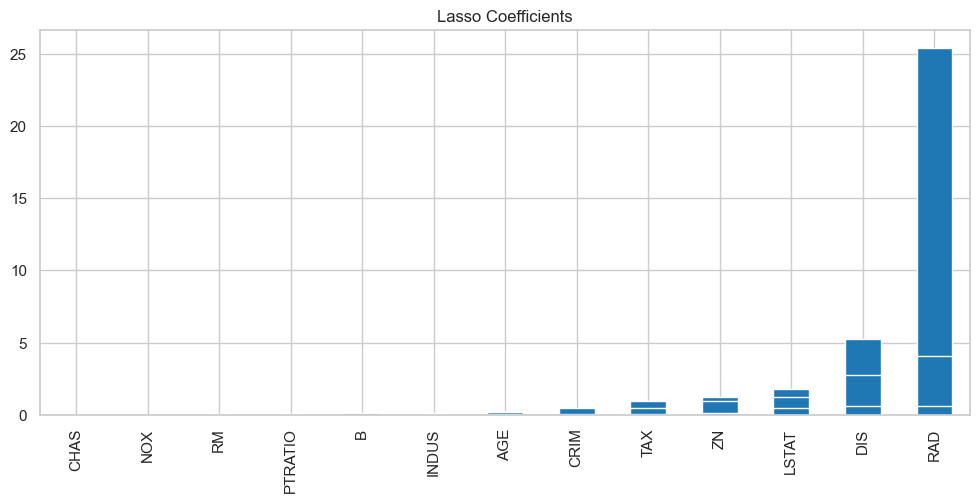

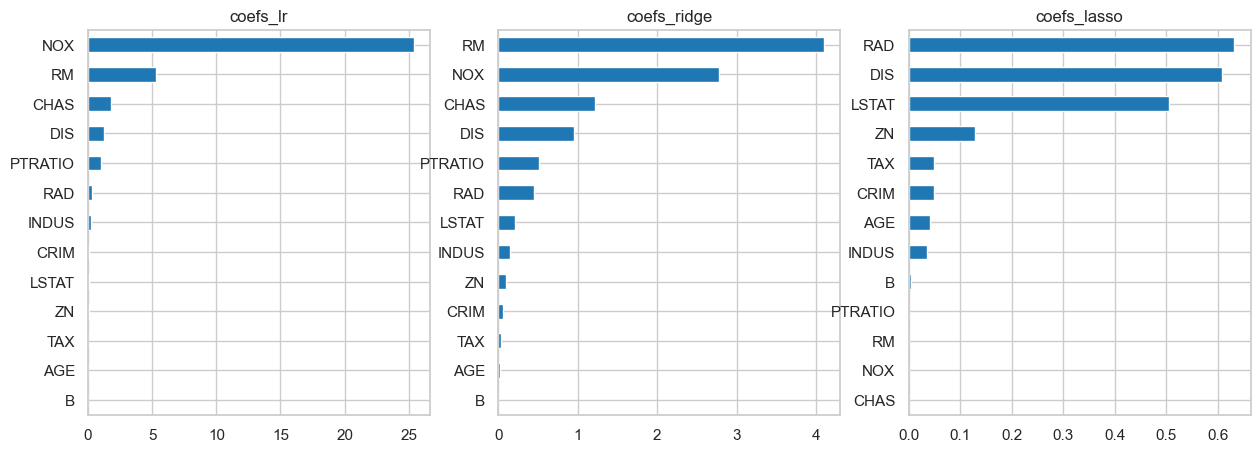

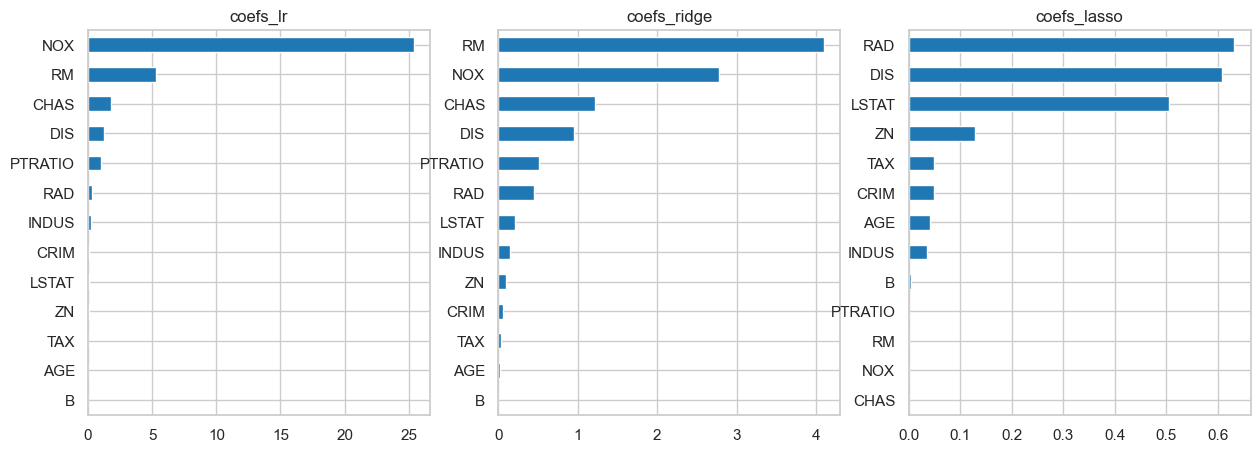

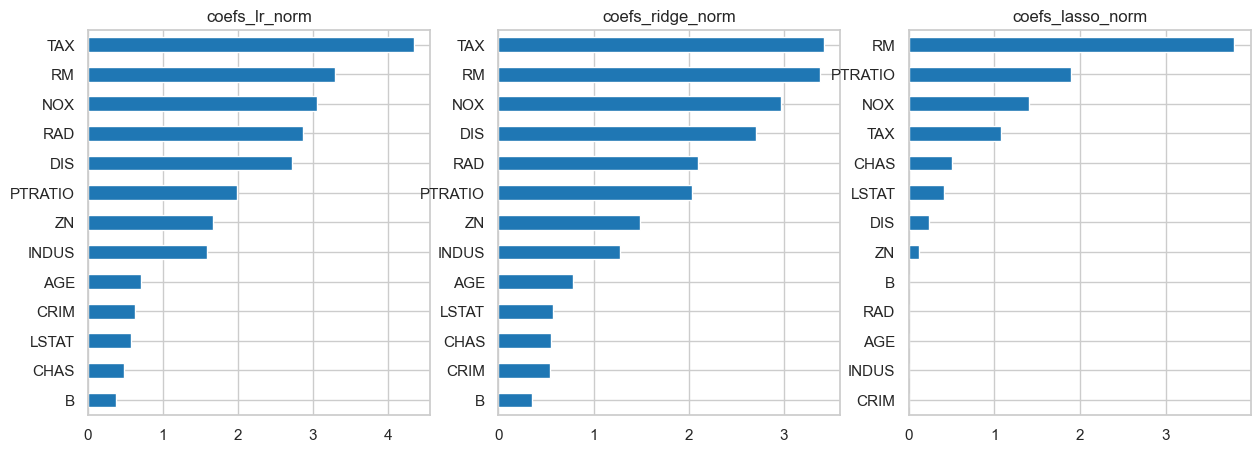

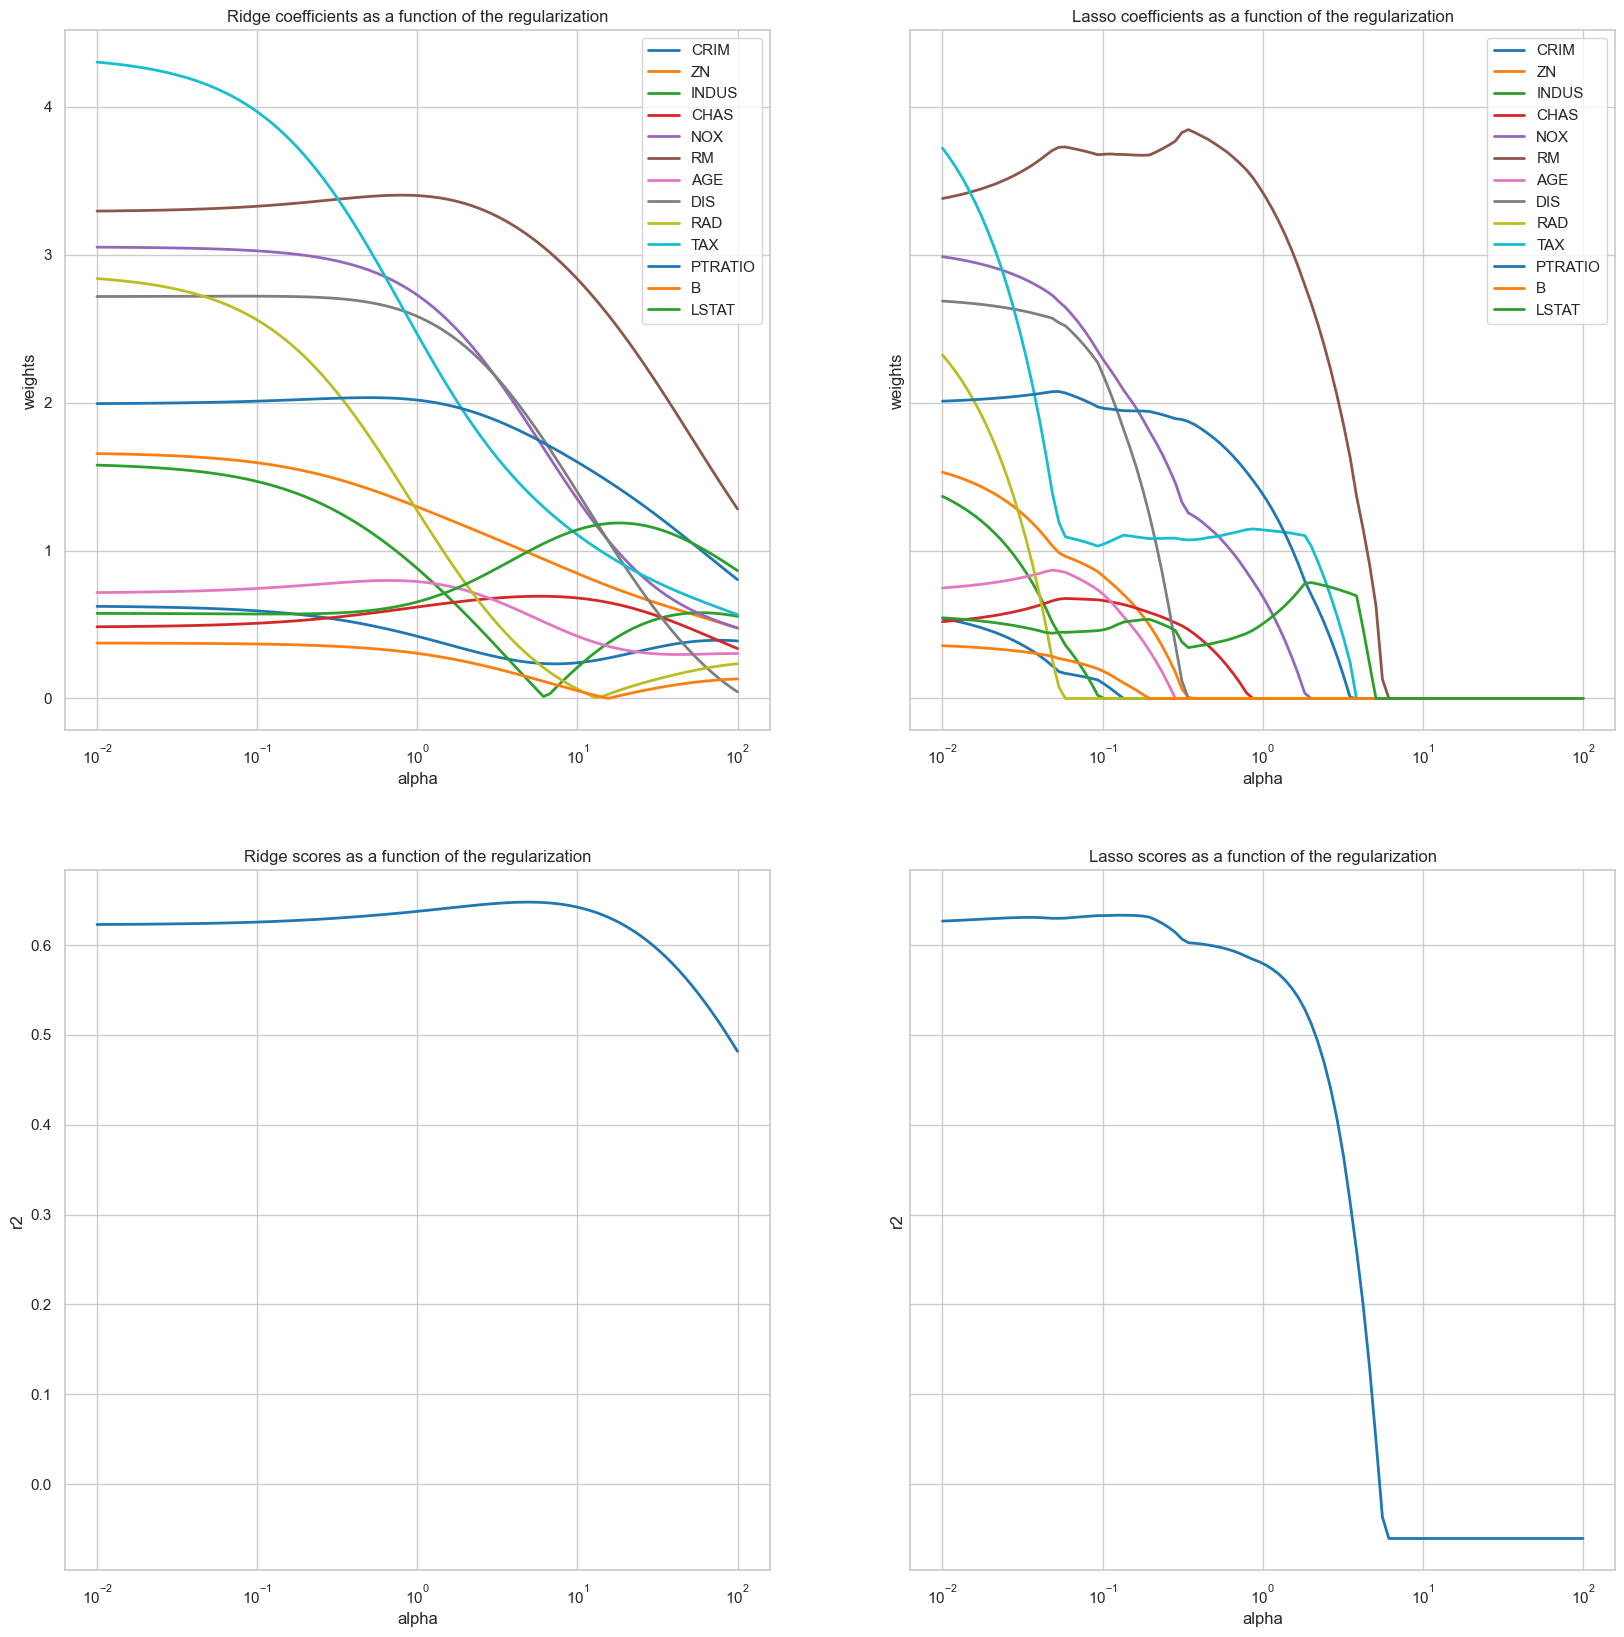

In [42]:
# Display results

fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey='row')


axs[0,0].plot(alphas, np.abs(coefs_ridge))
axs[0,0].set_xscale('log')
axs[0,0].set_title('Ridge coefficients as a function of the regularization')
axs[0,0].axis('tight')
axs[0,0].set_xlabel('alpha')
axs[0,0].set_ylabel('weights')
axs[0,0].legend(boston.feature_names)

axs[0,1].plot(alphas, np.abs(coefs_lasso))
axs[0,1].set_xscale('log')
axs[0,1].set_title('Lasso coefficients as a function of the regularization')
axs[0,1].axis('tight')
axs[0,1].set_xlabel('alpha')
axs[0,1].set_ylabel('weights')
axs[0,1].legend(boston.feature_names)

axs[1,0].plot(alphas, r2_ridge)
axs[1,0].set_xscale('log')
axs[1,0].set_title('Ridge scores as a function of the regularization')
axs[1,0].axis('tight')
axs[1,0].set_xlabel('alpha')
axs[1,0].set_ylabel('r2')

axs[1,1].plot(alphas, r2_lasso)
axs[1,1].set_xscale('log')
axs[1,1].set_title('Lasso scores as a function of the regularization')
axs[1,1].axis('tight')
axs[1,1].set_xlabel('alpha')
axs[1,1].set_ylabel('r2')


plt.show()

In [43]:
# Find optimal alphas
best_r2_ridge = max(r2_ridge)
max_index_ridge = r2_ridge.index(best_r2_ridge)
best_alpha_ridge = alphas[max_index_ridge]
print(max_index_ridge, best_alpha_ridge, best_r2_ridge, r2_ridge[max_index_ridge])

best_r2_lasso = max(r2_lasso)
max_index_lasso = r2_lasso.index(best_r2_lasso)
best_alpha_lasso = alphas[max_index_lasso]
print(max_index_lasso, best_alpha_lasso, best_r2_lasso, r2_lasso[max_index_lasso])

67 5.09413801481638 0.6477062785951346 0.6477062785951346
27 0.12328467394420665 0.6331388765145645 0.6331388765145645


In [44]:
print(r2score_test, r2score_train)

0.6224709227757259 0.8677571093777259


In [45]:
lasso = linear_model.Lasso(alpha=best_alpha_lasso)
lasso.fit(X_train_norm, y_train)
coefs = pd.Series(np.abs(lasso.coef_), features).sort_values()

In [46]:
coefs

INDUS      0.000000
RAD        0.000000
CRIM       0.044046
B          0.137279
LSTAT      0.483293
AGE        0.619532
CHAS       0.645262
ZN         0.745091
TAX        1.067572
PTRATIO    1.957578
DIS        1.961109
NOX        2.175540
RM         3.683385
dtype: float64

In [47]:
df = pd.DataFrame(X_train_norm, columns=features)

In [48]:
df['targ'] = y_train

In [49]:
features

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [50]:
sns.pairplot(df[['RM', 'NOX', 'DIS', 'PTRATIO', 'targ']])

### Selección de características con Sklearn

También podemos seleccionar las características más importantes con sklearn:

In [52]:
import sklearn.feature_selection as fs 
selector = fs.SelectKBest(score_func = fs.f_regression, k=5)

X_new_train = selector.fit_transform(X_train,y_train)
X_new_test = selector.transform(X_test)

print('Non important variables: {}'.format(boston.feature_names[selector.get_support()==False]))
print('Relevant variables: {}'.format(boston.feature_names[selector.get_support()]))

Non important variables: ['CRIM' 'ZN' 'CHAS' 'NOX' 'AGE' 'DIS' 'RAD' 'B']
Relevant variables: ['INDUS' 'RM' 'TAX' 'PTRATIO' 'LSTAT']


In [53]:
X_new_train.shape

(50, 5)

El conjunto de características seleccionadas ahora es diferente, ya que el criterio ha cambiado.

El método SelectKBest selecciona características según las k puntuaciones más altas. La puntuación se calcula usando la función score_func.
En este caso, utilizamos f_regression como nuestra función de puntuación, que devuelve la estadística F y los valores p de las pruebas de regresión lineal univariante de cada característica en X contra y.

**EJERCICIO 3** Diabetes:

El conjunto de datos de diabetes (de scikit-learn) consta de 10 variables fisiológicas (edad, sexo, peso, presión arterial) medidas en 442 pacientes, y una indicación de la progresión de la enfermedad después de un año.

Exploraremos el rendimiento del modelo de Regresión Lineal y el modelo LASSO para la predicción.

Completa los huecos del ejercicio.

Carga los datos

In [55]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
X,y = diabetes.data, diabetes.target
print(X.shape, y.shape)

(442, 10) (442,)


In [56]:
features = diabetes.feature_names
features

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Evalúa la predicción usando un modelo de regresión simple y un modelo de regresión múltiple.

In [58]:
df = pd.DataFrame(X, columns=features)
df['targ'] = y
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,targ
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [59]:
corr_mat = np.abs(df.corr())
sns.heatmap(corr_mat)

<Axes: >

In [60]:
sns.pairplot(data=df[['bmi', 's5', 'bp', 's4', 'targ']])

In [61]:
df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape, df_test.shape)

(353, 11) (89, 11)


Para el modelo simple, primero elige una de las dimensiones de los datos. Intenta realizar algunos gráficos para identificar posibles relaciones lineales entre las variables predictoras y las variables objetivo. Elige una variable para tu primer modelo.

In [63]:
X_train = df_train[['s5']]
y_train = df_train['targ']
print(X_train.shape, y_train.shape)

(353, 1) (353,)


In [64]:
X_test = df_test[['s5']]
y_test = df_test['targ']
print(X_test.shape, y_test.shape)

(89, 1) (89,)


In [65]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_train, y_train), lm.score(X_test, y_test))

0.32024660575659336 0.28593331909738295


Divide en conjuntos de entrenamiento y prueba y evalúa la predicción (sklearn) con un modelo de regresión múltiple.

In [67]:
X_train = df_train.drop(columns='targ')
y_train = df_train['targ']

X_test = df_test.drop(columns='targ')
y_test = df_test['targ']


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(353, 10) (353,)
(89, 10) (89,)


In [68]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_train, y_train), lm.score(X_test, y_test))

print(lm.coef_)

0.5174228628360156 0.48929529320500165
[ -37.76468651 -209.152775    531.9131173   306.11536413 -656.80322056
  398.19505074   80.03278862  187.46228148  716.59021876   86.26318959]


Para el modelo de regresión múltiple, divide en conjuntos de entrenamiento y prueba y evalúa la predicción (sklearn) sin y con regularización LASSO.

In [70]:
scaler = StandardScaler()
X_train_new = scaler.fit_transform(X_train)
X_test_new = scaler.transform(X_test)

In [71]:
lm = linear_model.Lasso(alpha=1)
lm.fit(X_train_new, y_train)
print(lm.score(X_train_new, y_train), lm.score(X_test_new, y_test))

0.5136153864768033 0.4785106336448176


In [72]:
pd.Series(np.abs(lm.coef_), features).sort_values()

s2      0.000000
s4      0.502420
age     0.549106
s1      2.833829
s6      3.423700
sex     8.069433
s3     10.133780
bp     13.136136
s5     24.064715
bmi    24.891730
dtype: float64

 Almost the same results with less "activated" coefficients (the result has 3 zero coefficients).
 
 Is the score different? How many predictors are we using now?


**EJERCICIO 4: Ventas de Big Mart**

Usa el [conjunto de datos de ventas de Big Mart](https://www.kaggle.com/brijbhushannanda1979/bigmart-sales-data). En el conjunto de datos, tenemos ventas de productos por producto para múltiples sucursales de una cadena.

En particular, podemos ver características del artículo vendido (contenido de grasa, visibilidad, tipo, precio) y algunas características de la sucursal (año de establecimiento, tamaño, ubicación, tipo) y el número de artículos vendidos para ese artículo en particular. Veamos si podemos predecir las ventas usando estas características.

Implementa el siguiente análisis:
- Lee los archivos de entrenamiento y prueba en un DataFrame de pandas
- Limpia los datos (hay algunos valores faltantes)
- Convierte las variables categóricas en valores numéricos y excluye 'Item_Identifier' y 'Item_Outlet_Sales' (que es el objetivo).
- Estudia cuáles son las variables con mayor (menor) correlación con la variable objetivo.
- Aplica regresión lineal usando todas las características.
- Construye el gráfico de residuos y da una interpretación del mismo
- Elige un modelo de regresión polinómica para ajustar mejor los datos.
- Compara los regresores de ridge y lasso.
- Compara la magnitud de los coeficientes de los diferentes modelos.
- Estima cuáles son las mejores características para la predicción.

Lee los archivos de entrenamiento y prueba en un DataFrame de pandas

In [76]:
# Load data:
df_train = pd.read_csv('files/ch06/bigmart-sales-data/Train.csv')

df_test = pd.read_csv('files/ch06/bigmart-sales-data/test.csv')

df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Limpia los datos (hay algunos valores faltantes).

In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Observa los datos faltantes en Item_Weight y Outlet_Size. Veamos cómo se ven estas variables.

In [80]:
print(df_train.Item_Weight.mean(), df_train.Item_Weight.std())
plt.hist(df_train.Item_Weight, bins=20)

12.857645184135976 4.643456499186395


(array([132., 351., 403., 467., 401., 464., 358., 306., 373., 406., 342.,
        287., 354., 401., 346., 389., 314., 363., 370., 233.]),
 array([ 4.555  ,  5.39475,  6.2345 ,  7.07425,  7.914  ,  8.75375,
         9.5935 , 10.43325, 11.273  , 12.11275, 12.9525 , 13.79225,
        14.632  , 15.47175, 16.3115 , 17.15125, 17.991  , 18.83075,
        19.6705 , 20.51025, 21.35   ]),
 <BarContainer object of 20 artists>)

In [81]:
# Replace nulls Item_Weight in with mean
mean_Item_Weight = df_train.Item_Weight.mean()
df_train2 =  df_train.copy()
df_test2 =  df_test.copy()

print(mean_Item_Weight)
df_train2[['Item_Weight']] = df_train2[['Item_Weight']].fillna(value=mean_Item_Weight)
df_test2[['Item_Weight']] = df_test2[['Item_Weight']].fillna(value=mean_Item_Weight)
df_train2[df_train.Item_Weight.isna()]

12.857645184135976


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,12.857645,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,12.857645,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,12.857645,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,12.857645,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,12.857645,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,12.857645,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,12.857645,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,12.857645,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,12.857645,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [82]:
sns.countplot(x="Outlet_Size", data=df_train2)

<Axes: xlabel='targ', ylabel='Count'>

In [83]:
df_train2[['Outlet_Size']].value_counts()

Outlet_Size
Medium         2793
Small          2388
High            932
Name: count, dtype: int64

In [84]:
# We'll fill the empty values of Outlet_Size with medium, since it´s the most common value.
df_train2[['Outlet_Size']] = df_train2[['Outlet_Size']].fillna(value='Medium')
df_test2[['Outlet_Size']] = df_test2[['Outlet_Size']].fillna(value='Medium')
df_train2[['Outlet_Size']].value_counts()

Outlet_Size
Medium         5203
Small          2388
High            932
Name: count, dtype: int64

Convierte las variables categóricas en valores numéricos y excluye 'Item_Identifier' y 'Item_Outlet_Sales' (que es el objetivo).

In [86]:
y = df_train2['Item_Outlet_Sales']

df_train2.drop(columns=['Item_Identifier','Item_Outlet_Sales'], inplace=True)
df_test2.drop(columns=['Item_Identifier'], inplace=True)

In [87]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 666.0+ KB


In [88]:
cols_num = ['Item_Weight', 'Item_Visibility', 'Item_MRP','Outlet_Establishment_Year']
cols_cat = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [89]:
for col in cols_cat:
    print()
    print(df_train2[[col]].value_counts())


Item_Fat_Content
Low Fat             5089
Regular             2889
LF                   316
reg                  117
low fat              112
Name: count, dtype: int64

Item_Type            
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

Outlet_Identifier
OUT027               935
OUT013               932
OUT035               930
OUT046               930
OUT049               930
OUT045               929
OUT018               928
OUT017               926
OUT010               555
OUT019               528
Name: count, dtype: int64

Outlet

In [90]:
df_train2 = pd.get_dummies(df_train2, drop_first=True)
df_test2 = pd.get_dummies(df_test2, drop_first=True)
df_test2

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,20.750000,0.007565,107.8622,1999,True,False,False,False,False,False,...,False,False,True,True,False,False,False,True,False,False
1,8.300000,0.038428,87.3198,2007,False,False,False,True,False,False,...,False,False,False,True,False,True,False,True,False,False
2,14.600000,0.099575,241.7538,1998,True,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,7.315000,0.015388,155.0340,2007,True,False,False,False,False,False,...,False,False,False,True,False,True,False,True,False,False
4,12.857645,0.118599,234.2300,1985,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,10.500000,0.013496,141.3154,1997,False,True,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
5677,7.600000,0.142991,169.1448,2009,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
5678,10.000000,0.073529,118.7440,2002,True,False,False,False,False,False,...,True,False,False,True,False,True,False,True,False,False
5679,15.300000,0.000000,214.6218,2007,False,True,False,False,False,False,...,False,False,False,True,False,True,False,True,False,False


Estudia cuáles son las variables con la mayor (menor) correlación con la variable objetivo.

In [92]:
cols_num = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
X_num = df_train2[cols_num].values
X_num_test = df_test2[cols_num].values
(X_num.shape, X_num_test.shape)

((8523, 4), (5681, 4))

In [93]:
from sklearn.preprocessing import StandardScaler

scalerX = StandardScaler().fit(X_num) # Create the transformer StandardScaler and perform the fitting for the training data

X_num = scalerX.transform(X_num)
X_num_test = scalerX.transform(X_num_test)

In [94]:
df_train2

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.300,0.016047,249.8092,1999,True,False,False,False,False,False,...,False,False,True,True,False,False,False,True,False,False
1,5.920,0.019278,48.2692,2009,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
2,17.500,0.016760,141.6180,1999,True,False,False,False,False,False,...,False,False,True,True,False,False,False,True,False,False
3,19.200,0.000000,182.0950,1998,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
4,8.930,0.000000,53.8614,1987,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,0.056783,214.5218,1987,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
8519,8.380,0.046982,108.1570,2002,False,True,False,False,False,False,...,True,False,False,True,False,True,False,True,False,False
8520,10.600,0.035186,85.1224,2004,True,False,False,False,False,False,...,False,False,False,False,True,True,False,True,False,False
8521,7.210,0.145221,103.1332,2009,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False


In [95]:
df_train2[cols_num] = X_num
df_test2[cols_num] = X_num_test
df_train2

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,-0.841872,-0.970732,1.747454,0.139541,True,False,False,False,False,False,...,False,False,True,True,False,False,False,True,False,False
1,-1.641706,-0.908111,-1.489023,1.334103,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False
2,1.098554,-0.956917,0.010040,0.139541,True,False,False,False,False,False,...,False,False,True,True,False,False,False,True,False,False
3,1.500838,-1.281758,0.660050,0.020085,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
4,-0.929428,-1.281758,-1.399220,-1.293934,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,-1.418084,-0.181193,1.180783,-1.293934,True,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
8519,-1.059578,-0.371154,-0.527301,0.497909,False,True,False,False,False,False,...,True,False,False,True,False,True,False,True,False,False
8520,-0.534243,-0.599784,-0.897208,0.736822,True,False,False,False,False,False,...,False,False,False,False,True,True,False,True,False,False
8521,-1.336444,1.532880,-0.607977,1.334103,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,True,False


In [96]:
df_train2['y'] = y
corr_mat = np.abs(df_train2.corr())

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, square=True, ax=ax)

<Axes: >

In [97]:
corr_mat.y.sort_values(ascending=False)

y                                  1.000000
Item_MRP                           0.567574
Outlet_Identifier_OUT027           0.311192
Outlet_Type_Supermarket Type3      0.311192
Outlet_Identifier_OUT019           0.277250
Item_Visibility                    0.128625
Outlet_Type_Supermarket Type1      0.108765
Outlet_Size_Small                  0.098403
Outlet_Size_Medium                 0.075154
Outlet_Location_Type_Tier 2        0.058261
Outlet_Identifier_OUT035           0.052823
Outlet_Establishment_Year          0.049135
Outlet_Location_Type_Tier 3        0.046376
Outlet_Type_Supermarket Type2      0.038059
Outlet_Identifier_OUT018           0.038059
Outlet_Identifier_OUT049           0.034264
Outlet_Identifier_OUT017           0.032610
Item_Type_Fruits and Vegetables    0.025950
Item_Type_Health and Hygiene       0.025587
Outlet_Identifier_OUT013           0.024170
Item_Type_Soft Drinks              0.024040
Item_Type_Snack Foods              0.022782
Item_Fat_Content_Regular        

Aplica regresión lineal utilizando todas las características.

In [99]:
X = df_train2.drop(columns=['y'])
X.shape

(8523, 39)

In [100]:
lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)

print(lr.score(X, y))

0.5638175299741153


Construye el gráfico de residuos y proporciona una interpretación del mismo.

In [102]:
sns.scatterplot(x = y_pred, y = y - y_pred, alpha=0.4)

plt.hlines(y=0, xmin= 0, xmax=y_pred.max())
plt.title('Residual plot')
plt.xlabel('$\hat y$')
plt.ylabel('$y - \hat y$')

Text(-121.25, 0.5, '$y - \\hat y$')

In [103]:
plt.scatter(y, y_pred, alpha=0.3)

plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.axis('tight')
plt.xlabel('$y$')
plt.ylabel('$\hat y$')

Text(-121.25, 0.5, '$\\hat y$')

Elige un modelo de regresión polinómica para ajustar mejor los datos.

In [105]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly = PolynomialFeatures(degree=2)
X2 = poly.fit_transform(X)

clf = linear_model.LinearRegression()
clf.fit(X2, y)

print(clf.score(X2, y))

0.62005707114371


Compara los regresores de ridge y lasso.

In [107]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso
#lr = LinearRegression()
#lr.fit(X, y)

ridge = Ridge(alpha=.5)
ridge.fit(X, y)

lasso = Lasso(alpha=.5)
lasso.fit(X, y)

print(lr.score(X, y), ridge.score(X, y), lasso.score(X, y))

0.5638175299741153 0.5638366656469606 0.5637677472777741


Compara la magnitud de los coeficientes de los diferentes modelos.

In [109]:
coefs_lr = pd.Series(lr.coef_, df_train2.columns[:-1]).sort_values()
coefs_ridge = pd.Series(ridge.coef_, df_train2.columns[:-1]).sort_values()
coefs_lasso = pd.Series(lasso.coef_, df_train2.columns[:-1]).sort_values()

In [110]:
print(coefs_lr)

Outlet_Identifier_OUT018          -8.348379e+15
Outlet_Location_Type_Tier 2       -4.081198e+15
Outlet_Identifier_OUT046          -2.889555e+15
Outlet_Location_Type_Tier 3       -2.603139e+15
Outlet_Identifier_OUT035          -2.500975e+15
Outlet_Size_Medium                -2.135093e+15
Outlet_Identifier_OUT017          -1.955216e+15
Outlet_Identifier_OUT049          -1.816279e+15
Outlet_Type_Supermarket Type1     -1.314377e+15
Outlet_Size_Small                 -6.783273e+12
Item_Type_Dairy                   -4.163139e+01
Item_Type_Household               -3.794016e+01
Item_Type_Frozen Foods            -2.840712e+01
Item_Type_Soft Drinks             -2.720752e+01
Item_Fat_Content_reg              -2.657829e+01
Item_Type_Others                  -2.028703e+01
Item_Visibility                   -1.627916e+01
Item_Type_Snack Foods             -1.151320e+01
Item_Type_Health and Hygiene      -9.200800e+00
Item_Type_Hard Drinks             -2.680460e+00
Item_Weight                       -2.246

In [111]:
print(coefs_ridge)

Outlet_Identifier_OUT019           -623.084512
Outlet_Location_Type_Tier 3        -368.620620
Outlet_Establishment_Year          -187.832436
Outlet_Size_Small                  -152.660810
Outlet_Size_Medium                 -129.627272
Outlet_Identifier_OUT045            -72.407097
Item_Type_Dairy                     -41.645731
Item_Type_Household                 -39.190737
Item_Fat_Content_reg                -29.811238
Item_Type_Soft Drinks               -27.747318
Item_Type_Frozen Foods              -27.601119
Item_Type_Others                    -21.054264
Item_Visibility                     -15.932813
Item_Type_Snack Foods               -11.478083
Item_Type_Health and Hygiene        -10.801048
Item_Weight                          -2.135196
Item_Type_Hard Drinks                -1.660770
Item_Type_Meat                       -1.046694
Item_Type_Breads                      3.917126
Item_Type_Breakfast                   7.004312
Item_Type_Canned                     24.949863
Item_Type_Sta

In [112]:
print(coefs_lasso)

Outlet_Identifier_OUT045           -153.349431
Outlet_Identifier_OUT046            -71.912999
Item_Type_Dairy                     -29.730101
Item_Type_Household                 -28.345935
Outlet_Location_Type_Tier 3         -23.061235
Item_Type_Frozen Foods              -17.931169
Item_Fat_Content_reg                -16.594755
Item_Visibility                     -16.219108
Item_Type_Soft Drinks               -12.481865
Item_Type_Snack Foods                -2.446712
Item_Weight                          -1.807733
Item_Type_Breakfast                   0.000000
Outlet_Size_Small                     0.000000
Outlet_Identifier_OUT019              0.000000
Outlet_Identifier_OUT017              0.000000
Outlet_Identifier_OUT013              0.000000
Item_Type_Starchy Foods               0.000000
Outlet_Location_Type_Tier 2           0.000000
Outlet_Size_Medium                   -0.000000
Item_Type_Meat                        0.000000
Item_Type_Health and Hygiene         -0.000000
Item_Type_Har

Estima cuáles son las mejores características para la predicción.

In [114]:
features = df_train2.columns[:-1]
features

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Item_Fat_Content_low fat',
       'Item_Fat_Content_reg', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 

In [115]:
import sklearn.feature_selection as fs 
selector = fs.SelectKBest(score_func = fs.f_regression,k=5)

X_new = selector.fit_transform(X,y)

print('Non important variables: {}'.format(features[selector.get_support()==False]))
print('Relevant variables: {}'.format(features[selector.get_support()]))

Non important variables: Index(['Item_Weight', 'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Item_Fat_Content_low fat',
       'Item_Fat_Content_reg', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2']

**ANÁLISIS ADICIONAL PARA LOS DATOS DE BOSTON**

Para comparar el ajuste de los modelos de regresión lineal y polinómica también podemos usar la biblioteca sklearn.

A continuación, añadimos una evaluación cuantitativa de los dos modelos.

In [117]:
boston = datasets.load_boston()
X_boston,y_boston = boston.data, boston.target

In [118]:
# Evaluation of the linear model
X_boston,y_boston = boston.data, boston.target

regr_boston = LinearRegression()
regr_boston.fit(X_boston, y_boston) 

#print('Coeff and intercept: {} {}'.format(regr_boston.coef_, regr_boston.intercept_))
print('Multiple Linear regression Score: {}'.format(regr_boston.score(X_boston, y_boston)))
print('Multiple Linear regression MSE: {}'.format(np.mean((regr_boston.predict(X_boston) - y_boston)**2)))

Multiple Linear regression Score: 0.7406426641094095
Multiple Linear regression MSE: 21.894831181729202


In [119]:
# Evaluation of the polynomial model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

regr_pol = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
regr_pol.fit(X_boston, y_boston) 

#print('Coeff and intercept: {} {}'.format(regr_pol.named_steps['linear'].coef_, regr_pol.named_steps['linear'].intercept_))
print('Multiple Polynomial regression Score: {}'.format(regr_pol.score(X_boston, y_boston)))
print('Multiple Polynomial regression MSE: {}'.format(np.mean((regr_pol.predict(X_boston) - y_boston)**2)))

Multiple Polynomial regression Score: 0.9289961714593019
Multiple Polynomial regression MSE: 5.994111690794211


Para la regresión simple, primero necesitamos extraer una de las características y luego usar los mismos métodos:

In [121]:
# Quantitative evaluation of the SIMPLE lineal and polynomial regression:
bostonDF = pd.DataFrame(boston.data)
bostonDF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [122]:
bostonDF.columns=boston.feature_names 
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [123]:
x=bostonDF['LSTAT']
y=boston.target
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

In [124]:
regr_boston = LinearRegression()
regr_boston.fit(x, y) 

print('Simple linear regression Score: {}'.format(regr_boston.score(x, y)))
print('Simple linear regression MSE: {}'.format(np.mean((regr_boston.predict(x) - y)**2)))

regr_pol = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])
regr_pol.fit(x, y) 

print('Simple Polynomial regression (order 2) Score: {}'.format(regr_pol.score(x, y)))
print('Simple Polynomial regression (order 2) MSE: {}'.format(np.mean((regr_pol.predict(x) - y)**2)))

regr_pol = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
regr_pol.fit(x, y) 

print('Simple Polynomial regression (order 3) Score: {}'.format(regr_pol.score(x, y)))
print('Simple Polynomial regression (order 3) MSE: {}'.format(np.mean((regr_pol.predict(x) - y)**2)))

Simple linear regression Score: 0.5441462975864797
Simple linear regression MSE: 38.48296722989415
Simple Polynomial regression (order 2) Score: 0.6407168971636611
Simple Polynomial regression (order 2) MSE: 30.330520075853716
Simple Polynomial regression (order 3) Score: 0.6578476405895719
Simple Polynomial regression (order 3) MSE: 28.884350319213173


**EJERCICIO 2: Conjunto de datos macroeconómicos**

Para comenzar, cargamos el conjunto de datos Longley de datos macroeconómicos de EE. UU. desde el sitio web de conjuntos de datos de R. Datos macroeconómicos desde 1947 hasta 1962.

In [126]:
# Read data
df = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/datasets/longley.csv', index_col=0)
df.head()

# Clean column names
df.columns = ['GNPdeflator', 'GNP', 'Unemployed', 'ArmedForces', 'Population','Year', 'Employed']
features = ['GNPdeflator','Unemployed','ArmedForces','Population','Year','Employed']
target = 'GNP'

# Create X matrix and y vector from the dataset
X = df[features].values
y = df[target].values

print('Shape of data: {} {}'.format(X.shape, y.shape))

Shape of data: (16, 6) (16,)


In [127]:
# Fitting a multiple linear model
lin_reg = LinearRegression() # Create the Linear Regression estimator
lin_reg.fit(X, y) # Perform the fitting


# Regrerssion coefs
coefs = pd.Series(lin_reg.coef_, features).sort_values()

# Prediction
y_pred = lin_reg.predict(X)

# evaluation
mse = mean_squared_error(y, y_pred)
r2score = lin_reg.score(X, y)

# The coefficients
print('\nIntercept and coefs:\n{} {}'.format(lin_reg.intercept_, lin_reg.coef_))
# The mean squared error
print('\nMSE: {}'.format(mse))
# The coefficient of determination: 1 is perfect prediction
print('R^2 Score: {}'.format(r2score))


Intercept and coefs:
-30213.91181055064 [ 1.50831401 -0.18594796 -0.05912791  4.82925005 15.43187147 -3.14815228]

MSE: 4.594588620500257
R^2 Score: 0.9995039255909312


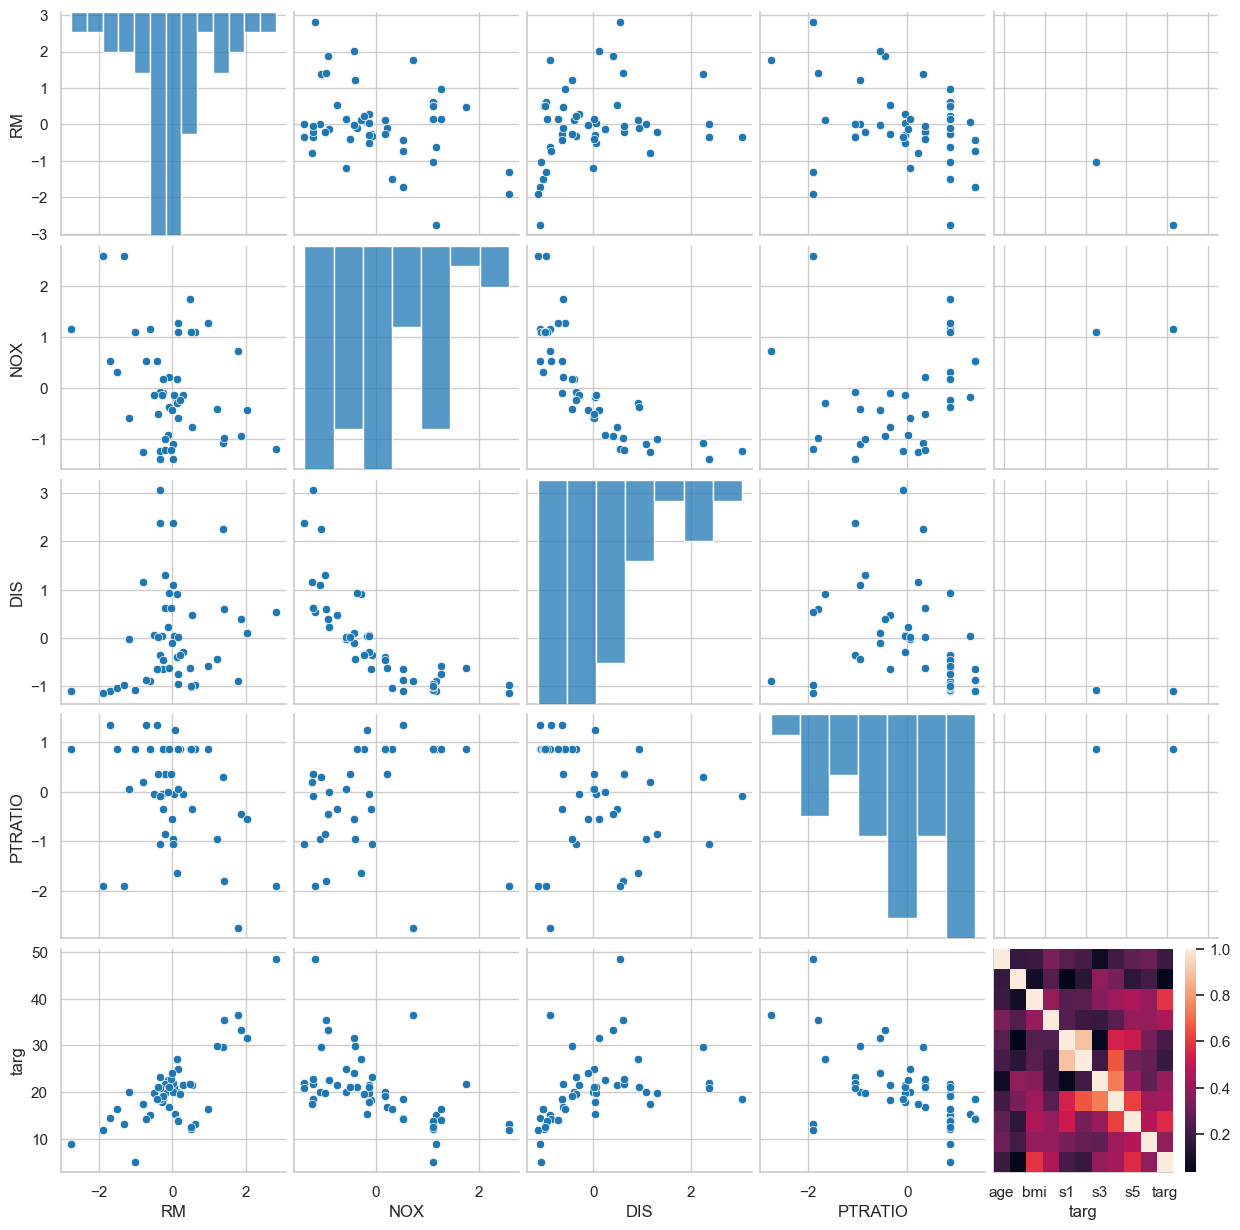

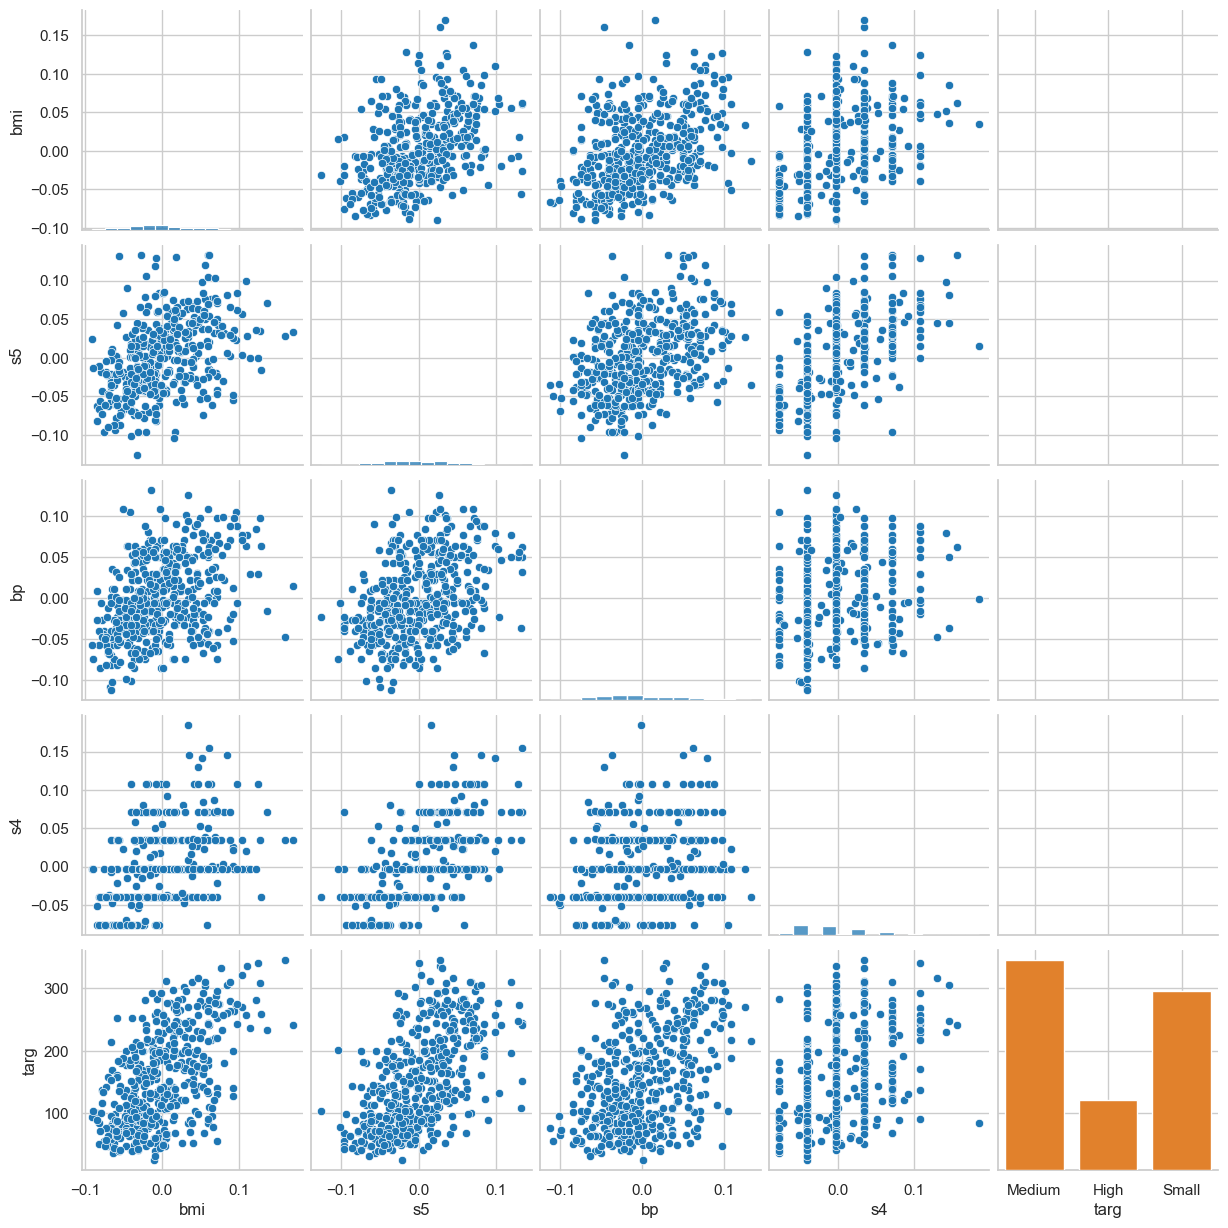

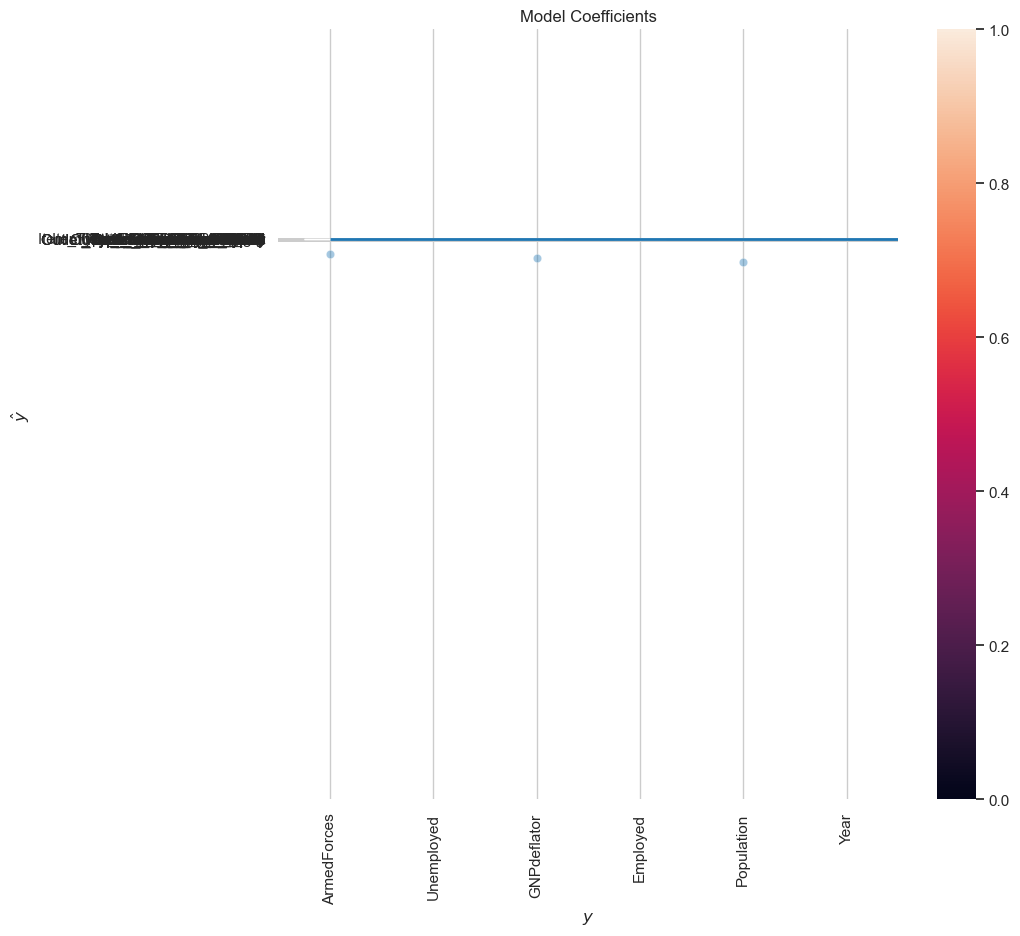

In [222]:
# Plotting abs value of model coefficients
np.abs(coefs).sort_values().plot(kind='bar', title='Model Coefficients')
plt.show()